# Predicting directors career outcomes 10 years after debut with early collaborators' social capital 

In this notebook, we test whether a director's career success is influenced by the brokerage social capital of the people they work with. We will use the cross-sectional data that summarizes each director's career 10 years after their debut to run Cox proportional hazard model testing the interactive effect between early collaborators' brokerage social capital and directors' gender in predicting the likelihood and the time it takes for a director to make a second movie after their debut year.

# 1. Check for multicollinearity

In [20]:
# Importing necessary libraries for data manipulation and handling
import pandas as pd  # data manipulation
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter

# Set the working directory to where the project files are located
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [21]:
directors_cross_sectional_complete = pd.read_csv("directors_cross_sectional_complete.csv")

In [22]:
directors_cross_sectional_complete.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies,debut_collaborator_avg_effective_size,director_predicted_gender,director_predicted_gender_binary,had_prior_experience,collaborator_movie_ratings_standardized,...,debut_year_2011,debut_year_2012,debut_year_2013,debut_collaborator_avg_effective_size_log,debut_collaborator_avg_effective_size_sqrt,debut_collaborator_avg_effective_size_winsorized,collaborator_movie_votes_log,collaborator_movie_votes_sqrt,collaborator_movie_votes_winsorized_standardized,debut_collaborator_avg_effective_size_winsorized_centered
0,nm1131265,2004,9.0,1,1.0,3.666667,Male,0.0,0,0.782853,...,0,0,0,1.540445,1.914854,3.666667,4.744932,10.677078,-0.225307,0.576294
1,nm1130611,2004,11.0,0,0.0,3.666667,Female,1.0,0,0.782853,...,0,0,0,1.540445,1.914854,3.666667,4.744932,10.677078,-0.225307,0.576294
2,nm0290651,2003,11.0,0,0.0,2.600000,Ambiguous,NaN,0,-1.187247,...,0,0,0,1.280934,1.612452,2.600000,7.266827,37.828561,-0.203513,-0.490373
3,nm0404033,2003,5.0,1,1.0,4.219048,NaN,NaN,0,-1.178952,...,0,0,0,1.652315,2.054032,4.219048,6.870053,31.016125,-0.211274,1.128675
4,nm0000417,2005,2.0,1,1.0,1.857143,Male,0.0,1,-0.523634,...,0,0,0,1.049822,1.362770,1.857143,7.377134,39.974992,-0.200750,-1.233230


In [23]:
directors_cross_sectional_complete.columns

Index(['nconst_director', 'debut_year', 'time_to_second_movie', 'event',
       'total_movies', 'debut_collaborator_avg_effective_size',
       'director_predicted_gender', 'director_predicted_gender_binary',
       'had_prior_experience', 'collaborator_movie_ratings_standardized',
       'collaborator_movie_votes', 'debut_year_2004', 'debut_year_2005',
       'debut_year_2006', 'debut_year_2007', 'debut_year_2008',
       'debut_year_2009', 'debut_year_2010', 'debut_year_2011',
       'debut_year_2012', 'debut_year_2013',
       'debut_collaborator_avg_effective_size_log',
       'debut_collaborator_avg_effective_size_sqrt',
       'debut_collaborator_avg_effective_size_winsorized',
       'collaborator_movie_votes_log', 'collaborator_movie_votes_sqrt',
       'collaborator_movie_votes_winsorized_standardized',
       'debut_collaborator_avg_effective_size_winsorized_centered'],
      dtype='object')

In [24]:
# Define the variables for multicollinearity check
variables_to_check = ['had_prior_experience', 'collaborator_movie_ratings_standardized', 'collaborator_movie_votes_winsorized_standardized', 
                      'debut_collaborator_avg_effective_size_winsorized_centered', 'director_predicted_gender_binary'] + [col for col in directors_cross_sectional_complete.columns if col.startswith('debut_year_')]

# Subset the dataframe for VIF calculation
X = directors_cross_sectional_complete[variables_to_check].dropna()
X = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,feature,VIF
0,const,20.837293
1,had_prior_experience,1.021327
2,collaborator_movie_ratings_standardized,1.020545
3,collaborator_movie_votes_winsorized_standardized,1.099275
4,debut_collaborator_avg_effective_size_winsoriz...,1.101653
5,director_predicted_gender_binary,1.014837
6,debut_year_2004,2.043306
7,debut_year_2005,2.173286
8,debut_year_2006,2.360131
9,debut_year_2007,2.393276


The Variance Inflation Factor (VIF) results indicate that there is no significant multicollinearity among the variables, as all VIF values are below 5.

# 2. Predicting the likelihood of and time to the second movie after debut 

In [25]:
# Create the interaction term
directors_cross_sectional_complete['interaction_effective_size_gender'] = directors_cross_sectional_complete['debut_collaborator_avg_effective_size_winsorized_centered'] * directors_cross_sectional_complete['director_predicted_gender_binary']

# Define control variables
control_vars = ['had_prior_experience', 'collaborator_movie_ratings_standardized', 'collaborator_movie_votes_winsorized_standardized']+[col for col in directors_cross_sectional_complete.columns if col.startswith('debut_year_')]

# Define model specifications
models = {
    'model_1': ['debut_collaborator_avg_effective_size_winsorized_centered'],
    'model_2': ['director_predicted_gender_binary'],
    'model_3': ['debut_collaborator_avg_effective_size_winsorized_centered', 'director_predicted_gender_binary', 'interaction_effective_size_gender'],
    'model_4': ['debut_collaborator_avg_effective_size_winsorized_centered'] + control_vars,
    'model_5': ['director_predicted_gender_binary'] + control_vars,
    'model_6': ['debut_collaborator_avg_effective_size_winsorized_centered', 'director_predicted_gender_binary', 'interaction_effective_size_gender'] + control_vars
}

# Initialize the CoxPHFitter
cph = CoxPHFitter()

# Variable to store the CoxPHFitter object for model 6
cph_model_6 = None

# Function to fit and summarize CoxPH model
def fit_and_summarize_model(df, model_vars):
    model_data = df[['time_to_second_movie', 'event'] + model_vars].dropna()
    cph.fit(model_data, duration_col='time_to_second_movie', event_col='event')
    
    # Extract additional information
    n_obs = cph._n_examples
    n_events = cph.event_observed.sum()
    model_df = len(model_vars)
    log_likelihood = cph.log_likelihood_
    
    # Return summary and additional information
    return {
        'summary': cph.summary,
        'n_obs': n_obs,
        'n_events': n_events,
        'model_df': model_df,
        'log_likelihood': log_likelihood
    }

In [26]:
# Fit and summarize each model
model_summaries = {}
for name, vars in models.items():
    result = fit_and_summarize_model(directors_cross_sectional_complete, vars)
    model_summaries[name] = result
    if name == 'model_6':
        cph_model_6 = cph  # Store the CoxPHFitter object for model 6

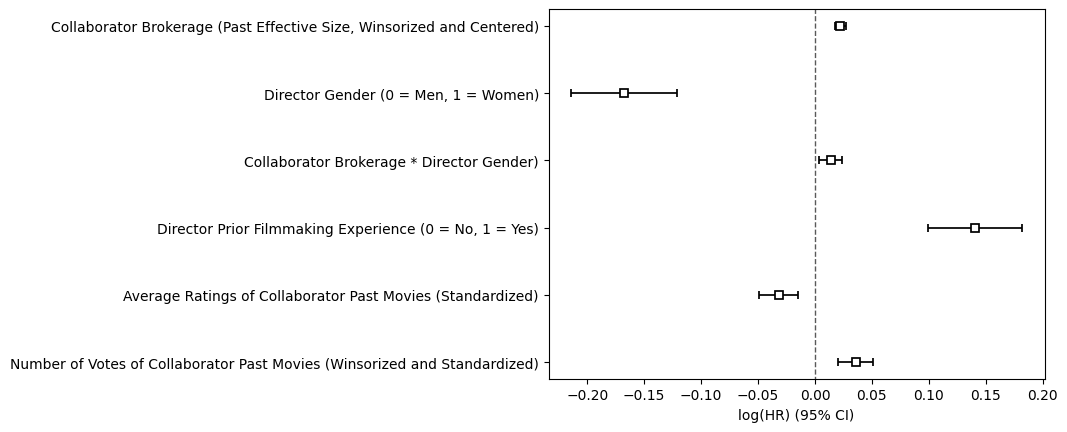

In [28]:
# Plot the results for model 6 including only specified variables
plot_vars = [
        'debut_collaborator_avg_effective_size_winsorized_centered',
        'director_predicted_gender_binary',
        'interaction_effective_size_gender',
        'had_prior_experience',
        'collaborator_movie_ratings_standardized',
        'collaborator_movie_votes_winsorized_standardized'
    ]

# Customize the plot
ax = cph_model_6.plot(columns=plot_vars)

# Set custom labels
custom_labels = {
        'debut_collaborator_avg_effective_size_winsorized_centered': 'Collaborator Brokerage (Past Effective Size, Winsorized and Centered)',
        'director_predicted_gender_binary': 'Director Gender (0 = Men, 1 = Women)',
        'interaction_effective_size_gender': 'Collaborator Brokerage * Director Gender)',
        'had_prior_experience': 'Director Prior Filmmaking Experience (0 = No, 1 = Yes)',
        'collaborator_movie_ratings_standardized': 'Average Ratings of Collaborator Past Movies (Standardized)',
        'collaborator_movie_votes_winsorized_standardized': 'Number of Votes of Collaborator Past Movies (Winsorized and Standardized)'
    }

ax.set_yticklabels([custom_labels.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()])   
plt.show()


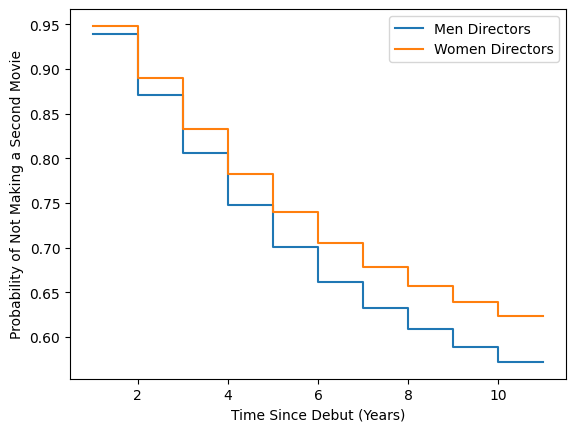

In [29]:
# Plot the survival function for men (director_predicted_gender_binary = 0) and women (director_predicted_gender_binary = 1)
fig, ax = plt.subplots()
cph_model_6.plot_partial_effects_on_outcome('director_predicted_gender_binary', values=[0, 1], ax=ax, plot_baseline=False)

# Set custom labels for the plot
ax.set_xlabel('Time Since Debut (Years)')
ax.set_ylabel('Probability of Not Making a Second Movie')
ax.legend(['Men Directors', 'Women Directors'])

plt.show()

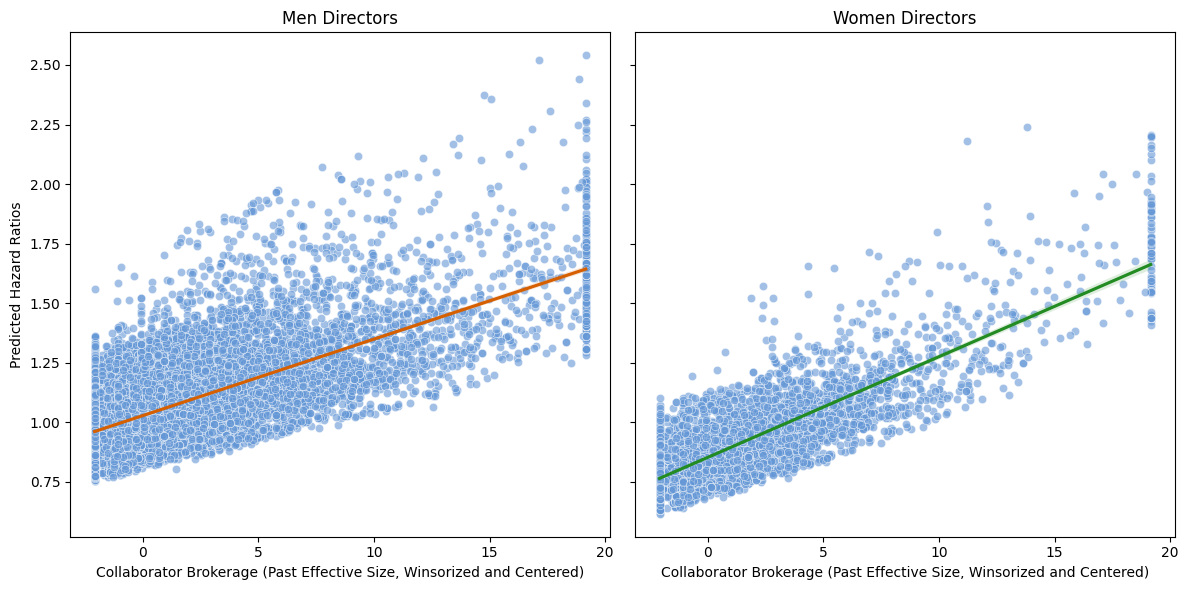

In [31]:
model_data = directors_cross_sectional_complete[['time_to_second_movie', 'event'] + ['debut_collaborator_avg_effective_size_winsorized_centered', 'director_predicted_gender_binary', 'interaction_effective_size_gender'] + control_vars].dropna()
# Predict hazard ratios
directors_cross_sectional_complete['predicted_hazard_ratios'] = cph_model_6.predict_partial_hazard(model_data)

# Scatterplot of predicted hazard ratios
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Men
sns.scatterplot(x='debut_collaborator_avg_effective_size_winsorized_centered', y='predicted_hazard_ratios', data=directors_cross_sectional_complete[directors_cross_sectional_complete['director_predicted_gender_binary'] == 0], ax=ax[0], alpha=0.6, color='#6497D6')
sns.regplot(x='debut_collaborator_avg_effective_size_winsorized_centered', y='predicted_hazard_ratios', data=directors_cross_sectional_complete[directors_cross_sectional_complete['director_predicted_gender_binary'] == 0], ax=ax[0], scatter=False, ci=95, color='#D65F00')
ax[0].set_title('Men Directors')
ax[0].set_xlabel('Collaborator Brokerage (Past Effective Size, Winsorized and Centered)')
ax[0].set_ylabel('Predicted Hazard Ratios')

# Women
sns.scatterplot(x='debut_collaborator_avg_effective_size_winsorized_centered', y='predicted_hazard_ratios', data=directors_cross_sectional_complete[directors_cross_sectional_complete['director_predicted_gender_binary'] == 1], ax=ax[1], alpha=0.6, color='#6497D6')
sns.regplot(x='debut_collaborator_avg_effective_size_winsorized_centered', y='predicted_hazard_ratios', data=directors_cross_sectional_complete[directors_cross_sectional_complete['director_predicted_gender_binary'] == 1], ax=ax[1], scatter=False, ci=95, color='#228B22')
ax[1].set_title('Women Directors')
ax[1].set_xlabel('Collaborator Brokerage (Past Effective Size, Winsorized and Centered)')

plt.tight_layout()
plt.show()

In [35]:
# Define the variables
selected_variables = [
    'debut_collaborator_avg_effective_size_winsorized_centered',
    'director_predicted_gender_binary',
    'interaction_effective_size_gender',
    'had_prior_experience',
    'collaborator_movie_ratings_standardized',
    'collaborator_movie_votes_winsorized_standardized'
]

# Define the model names
model_names = ["model_1", "model_2", "model_3", "model_4", "model_5", "model_6"]

# Initialize the DataFrame with selected variables and model names
regression_table = pd.DataFrame(index=selected_variables, columns=model_names)

# Populate the DataFrame with coefficients, standard errors, and significance for selected variables
for model_name, model_data in model_summaries.items():
    summary = model_data['summary']
    for var in selected_variables:
        if var in summary.index:
            coef = summary.loc[var, 'coef']
            se = summary.loc[var, 'se(coef)']
            p = summary.loc[var, 'p']
            significance = ""
            if p < 0.001:
                significance = "***"
            elif p < 0.01:
                significance = "**"
            elif p < 0.05:
                significance = "*"
            regression_table.loc[var, model_name] = f"{coef:.2f} ({se:.3f}){significance}"
        else:
            regression_table.loc[var, model_name] = ""

# Add additional information for each model
additional_info = {
    'n_obs': {model: model_summaries[model]['n_obs'] for model in model_names},
    'n_events': {model: model_summaries[model]['n_events'] for model in model_names},
    'model_df': {model: model_summaries[model]['model_df'] for model in model_names},
    'log_likelihood': {model: model_summaries[model]['log_likelihood'] for model in model_names}
}

# Convert additional information to DataFrame and transpose it
additional_info_df = pd.DataFrame(additional_info).T

# Concatenate the regression table with the additional information
regression_table = pd.concat([regression_table, additional_info_df])


In [36]:
regression_table

,model_1,model_2,model_3,model_4,model_5,model_6
debut_collaborator_avg_effective_size_winsorized_centered,0.03 (0.002)***,,0.03 (0.002)***,0.02 (0.002)***,,0.02 (0.002)***
director_predicted_gender_binary,,-0.17 (0.019)***,-0.20 (0.019)***,,-0.13 (0.022)***,-0.17 (0.024)***
interaction_effective_size_gender,,,0.02 (0.005)***,,,0.01 (0.005)**
had_prior_experience,,,,0.14 (0.019)***,0.15 (0.021)***,0.14 (0.021)***
collaborator_movie_ratings_standardized,,,,-0.04 (0.008)***,-0.04 (0.009)***,-0.03 (0.009)***
collaborator_movie_votes_winsorized_standardized,,,,0.04 (0.007)***,0.06 (0.007)***,0.04 (0.008)***
n_obs,58869.0,49443.0,46224.0,40458.0,31587.0,31587.0
n_events,22706.0,17893.0,17584.0,16752.0,12938.0,12938.0
model_df,1.0,1.0,3.0,14.0,14.0,16.0
log_likelihood,-244127.258108,-189638.960301,-184801.205386,-173405.787305,-130788.499072,-130725.290607


In [34]:
print(regression_table.to_latex())

\begin{tabular}{lllllll}
\toprule
 & model_1 & model_2 & model_3 & model_4 & model_5 & model_6 \\
\midrule
debut_collaborator_avg_effective_size_winsorized_centered & 0.03 (0.00)*** &  & 0.03 (0.00)*** & 0.02 (0.00)*** &  & 0.02 (0.00)*** \\
director_predicted_gender_binary &  & -0.17 (0.02)*** & -0.20 (0.02)*** &  & -0.13 (0.02)*** & -0.17 (0.02)*** \\
interaction_effective_size_gender &  &  & 0.02 (0.00)*** &  &  & 0.01 (0.01)** \\
had_prior_experience &  &  &  & 0.14 (0.02)*** & 0.15 (0.02)*** & 0.14 (0.02)*** \\
collaborator_movie_ratings_standardized &  &  &  & -0.04 (0.01)*** & -0.04 (0.01)*** & -0.03 (0.01)*** \\
collaborator_movie_votes_winsorized_standardized &  &  &  & 0.04 (0.01)*** & 0.06 (0.01)*** & 0.04 (0.01)*** \\
n_obs & 58869.000000 & 49443.000000 & 46224.000000 & 40458.000000 & 31587.000000 & 31587.000000 \\
n_events & 22706.000000 & 17893.000000 & 17584.000000 & 16752.000000 & 12938.000000 & 12938.000000 \\
model_df & 1.000000 & 1.000000 & 3.000000 & 14.000000 & 14.